In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct  4 17:57:07 2025

@author: coletamburri
"""


from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib as mpl
import tol_colors
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.io import readsav
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy


def normalize(arr):
    norm_arr = []
    minimum = np.nanmin(arr)
    maximum = np.nanmax(arr)
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr

def normalize_range(arr,lowlim=0,highlim=-1,contmin = 0):
    if contmin > 0:
        minimum = arr[contmin]
    else:
        minimum = np.nanmin(arr[lowlim:highlim])
    maximum = np.nanmax(arr[lowlim:highlim])
    diff_arr = maximum - minimum   
    return (arr-minimum)/diff_arr  

c=2.99e5
lamb0 = 396.847
lamb1 = 397.01
lamb2 = 486.1
mu1 = 0.4760111410077789
mu2 = 0.4266927415494022
mu3=.54
muhead = 1
saving=0

#ViSP instrument
fwhm = .003 # in nm # 0.003 is from the convolution and comparison to atlas, 
            #but 0.01 makes RADYN/DKIST match a lot better? extra gaussian impact somewhere?
            # 0.001 to preserve shape of Hbeta in care for deep heating...
flagh20 = 1
flagh20sum = 0

#only one of the following should be 1
flagb = 0
flagvt = 0
flagt = 0

hepwl=397.01

heplowh20 = 690
hephighh20 = 850

caII_low = 630
caII_high = 670
hep_low = 730
hep_high = 900



lowvisp=148
highvisp=148+91
#lowvisp=0
#highvisp=-1

def veltrans(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian(x, c1, mu1, sigma1):
    res = c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

def gaussfit(params,selwl,sel):
    fit = gaussian( selwl, params )
    return (fit - sel)

def double_gaussian( x, c1, mu1, sigma1, c2, mu2, sigma2 ):
    res =   (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )) \
          + (c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    return res

def tocgs(self, w, s):
    clight=2.99792458e10         #speed of light [cm/s]
    joule_2_erg=1e7
    aa_to_cm=1e-8
    s *=joule_2_erg/aa_to_cm # from Watt /(cm2 ster AA) to erg/(s cm2 ster cm)
    s *=(w*aa_to_cm)**2/clight   # to erg/
    return s

def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

#example convolution with gaussian psf
def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr

#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range):
   
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    #dw=new_dispersion_range[1]-new_dispersion_range[0]
    #dw=dw
    #tw=(np.arange(ntw)-ntw//2)*dw
    
    stddev_pixels = fwhm/(new_dispersion_range[1]-new_dispersion_range[0])
    gaussian_kernel = Gaussian1DKernel(stddev=stddev_pixels)
   	
    #psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    #yconv = convolve(yatlas, psf, mode='same', method='fft')
    yconv = convolve(yatlas,gaussian_kernel)
    
    return yconv

def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.nm)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

In [33]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [34]:
#load DKIST spectra
dkist_file = '/Users/coletamburri/Desktop/11Aug2024_Cclass_CaIIH_calib_bestseeing.npz'
dkist_file = np.load(dkist_file)


dkist_wl = dkist_file['wl']
dkist_int = dkist_file['flare']
dkist_avg = np.mean(dkist_int[lowvisp:highvisp,caII_low:caII_high,:],1)
dkist_time = dkist_file['time']

In [35]:
dkist_coord_file = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSPcoords.npz'
dkist_coords = np.load(dkist_coord_file)

xarr_caII = dkist_coords['xarr_caII']
yarr_caII = dkist_coords['yarr_caII']

xarr_hbeta = dkist_coords['xarr_hbeta']
yarr_hbeta = dkist_coords['yarr_hbeta']

In [71]:
#define models to compare
base = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/'

modelnameqs0 = 'rhf1d_11Aug_Cclass_A_final_0s_mu0.npz' 
modelnameqs05 = 'rhf1d_11Aug_Cclass_A_final_0s_mu0.5.npz' 
modelnameqs1 = 'rhf1d_11Aug_Cclass_A_final_0s_mu1.npz' 

modelnameqs0_dh = 'rhf1d_11Aug_Cclass_deepheating_0s_mu0.npz' 
modelnameqs05_dh = 'rhf1d_11Aug_Cclass_deepheating_0s_mu0.5.npz' 
modelnameqs1_dh = 'rhf1d_11Aug_Cclass_deepheating_0s_mu1.npz' 

modelnameqs0_EBd = 'rhf1d_11Aug_Cclass_EB_d_0s_mu0.npz'
modelnameqs05_EBd = 'rhf1d_11Aug_Cclass_EB_d_0s_mu0.5.npz'
modelnameqs1_EBd = 'rhf1d_11Aug_Cclass_EB_d_0s_mu1.npz'

modelnameqs0_PBd = 'rhf1d_11Aug_Cclass_PB_d_0s_mu0.npz'
modelnameqs05_PBd = 'rhf1d_11Aug_Cclass_PB_d_0s_mu0.5.npz'
modelnameqs1_PBd = 'rhf1d_11Aug_Cclass_PB_d_0s_mu1.npz'

modelnameqs0_EBPBd = 'rhf1d_11Aug_Cclass_EBPB_d_0s_mu0.npz'
modelnameqs05_EBPBd = 'rhf1d_11Aug_Cclass_EBPB_d_0s_mu0.5.npz'
modelnameqs1_EBPBd = 'rhf1d_11Aug_Cclass_EBPB_d_0s_mu1.npz'

modelnameqs0_TCd = 'rhf1d_11Aug_Cclass_TC_d_0s_mu0.npz'
modelnameqs05_TCd = 'rhf1d_11Aug_Cclass_TC_d_0s_mu0.5.npz'
modelnameqs1_TCd = 'rhf1d_11Aug_Cclass_TC_d_0s_mu1.npz'

modelnameqs0_EBTCd = 'rhf1d_11Aug_Cclass_EBTC_d_0s_mu0.npz'
modelnameqs05_EBTCd = 'rhf1d_11Aug_Cclass_EBTC_d_0s_mu0.5.npz'
modelnameqs1_EBTCd = 'rhf1d_11Aug_Cclass_EBTC_d_0s_mu1.npz'

feature = 'deepheating' #red or deepheating or symmetric or blueshift
saving = 0 # if saving pixel values to file
models = []
# for redshift figure
if feature == 'red':
    models.append('11Aug_Cclass_D_final_22s_mu1.npz') #region D, 22s (time-consistent; small redshift)
    models.append('11Aug_Cclass_A_final_7s_mu1.npz') #region AB, 7s (big redshift)
    models.append('rhf1d_11Aug_Cclass_TC_8s_mu1.npz') # region D, TC, 8s (some redshift)
    models.append('rhf1d_11Aug_Cclass_EB+TC_8s_mu1.npz') # region D, EB+TC, 8s (more redshift than TC
elif feature == 'deepheating':
    models.append('rhf1d_11Aug_Cclass_deepheating_12s_mu0.npz')# also deepheating at 12s with mu close to 0?
    models.append('rhf1d_11Aug_Cclass_deepheating_12s_mu0.5.npz')# also deepheating at 12s with mu close to 0.5?
    models.append('11Aug_Cclass_deepheating_12s_mu1.npz') #deepheating, 12s 
    
    RADYNonly_dh = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_deepheating.sav'
elif feature == 'symmetric':
    models.append('11Aug_Cclass_A_final_36s_5vt_mu1.npz') #time-consistent model for region AB
    models.append('11Aug_Cclass_A_final_36s_7vt_mu0.5.npz')#same but at mu=0.5
    models.append('11Aug_Cclass_A_final_36s_5vt_mu0.5.npz')#same but at mu=0.5

    #extra models - to explain small redshifts?
    models.append('11Aug_Cclass_A_final_7s_mu1.npz') #region AB, 7s (big redshift)
    models.append('rhf1d_11Aug_Cclass_EB+TC_8s_mu1.npz') # region D, EB+TC, 8s (more redshift than TC
elif feature == 'blueshift':
    models.append('rhf1d_11Aug_Cclass_D_proton_35s_mu1.npz') # proton beam at 35 post-RH
    models.append('11Aug_Cclass_regionD_proton_21s_mu1.npz') # proton beam at 21 post-RH
    models.append('rhf1d_11Aug_Cclass_gentleevap_13s_mu1.npz') # gentle evaporation at 13 s post-RH
    RADYNonly_proton = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_Cclass_d_proton_v2.sav'
    RADYNonly_ge = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_gentleevaptake2.sav'
    






In [72]:
# put pixels of note here

if feature == 'red':
    cc=[(np.float64(47.151209677419345), np.float64(1310.3674677306415)),
     (np.float64(49.71975806451612), np.float64(1310.3674677306415)),
     (np.float64(52.104838709677416), np.float64(1323.875018165964)),
     (np.float64(54.12298387096774), np.float64(1334.005680992456)),
     (np.float64(55.95766129032258), np.float64(1344.136343818948)),
     (np.float64(58), np.float64(1346)),
     (np.float64(59.26008064516128), np.float64(1354.2670066454398)),
     (np.float64(61.27822580645161), np.float64(1350.8901190366093)),
     (np.float64(64.7641129032258), np.float64(1337.3825686012867))]
if feature == 'deepheating':
    cc=[(np.float64(72.4259206394519), np.float64(1303.5101727025612)),
     (np.float64(74.71196117613475), np.float64(1303.5101727025612)),
     (np.float64(68.26948330002855), np.float64(1331.5818895692041)),
     (72,1317),(75,1317),(75,1328)]

if feature == 'symmetric':
    cc=[(np.float64(77), np.float64(1145)),
     (np.float64(68.17699712886336), np.float64(1150.9730071318945)),
     (np.float64(72.17294375950007), np.float64(1157.5658184913395)),
     (np.float64(75.86150988008782), np.float64(1150.9730071318945)),
     (np.float64(77.70579294038168), np.float64(1134.4909787332822)),
     (np.float64(78.9353149805776), np.float64(1121.3053560143924)),
     (np.float64(79.85745651072453), np.float64(1098.2305162563352)),
     (np.float64(75.24674885998986), np.float64(1108.1197332955026)),
     (np.float64(70.63604120925518), np.float64(1118.00895033467)),
     (80,1043),(75,1059),(82,1083) ]

if feature == 'blueshift':
    cc=[(np.float64(81.05723204994797), np.float64(854.3627028362753)),
     (np.float64(84.03329864724245), np.float64(857.8716674446059)),
     (np.float64(84.3038501560874), np.float64(812.2551275363112)),
     #(np.float64(83.7627471383975), np.float64(770.1475522363467)),
      (78,782),
     #(np.float64(80.2455775234131), np.float64(756.1116938030254)),
     (np.float64(78), np.float64(756.1116938030254)),
     (np.float64(75.10509885535899), np.float64(735.0579061530434)),
     (np.float64(78.35171696149844), np.float64(766.6385876280165)),
     (np.float64(81.32778355879292), np.float64(794.7103044946593)),
     (np.float64(81.32778355879292), np.float64(826.2909859696324)),
      (65,782),
      (68,798),
      (75,782),
      (45,645),
      (55,645)]


In [73]:
saving=0
# convert the pixel numbers to spatial coordinates
x_select = []
y_select = []
for i in range(len(cc)):
    x_select.append(xarr_caII[int(cc[i][0])])
    y_select.append(yarr_caII[int(cc[i][1])])

#convert these spatial coordinates to coordinates in the other frame
x_other_inds = []
y_other_inds = []

for i in range(len(x_select)):
    x_other_inds.append(find_nearest(xarr_hbeta,x_select[i])[1])
    y_other_inds.append(find_nearest(yarr_hbeta,y_select[i])[1])

    # and print to file

if saving == 1:
    hbeta_inds_file ='/Users/coletamburri/Desktop/Hbeta_inds_'+feature+'.npz'
    np.savez(hbeta_inds_file,x_other_inds = x_other_inds,y_other_inds=y_other_inds,x_coords_arcsec=x_select,y_coords_arcsec=y_select)

[]

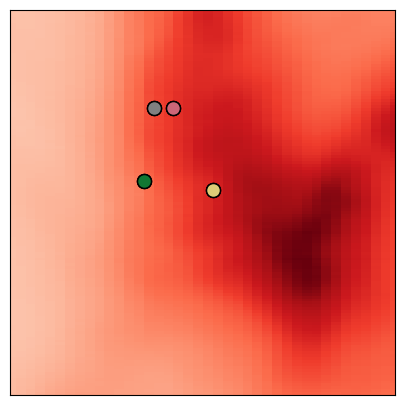

In [74]:
colors=tol_colors.tol_cset('muted')

if feature=='symmetric':
    choice_is = [2,7,8,10,11]
elif feature=='blueshift':
    choice_is = [3,6,9,11]
elif feature=='red':
    choice_is = [3,5,6,7]
elif feature=='deepheating':
    choice_is = [0,1,2,5]
    

dkist_blue = dkist_int[lowvisp:highvisp,caII_low-20,:]
dkist_center = dkist_int[lowvisp:highvisp,int(round(caII_high+caII_low)/2),:]

fig,ax=plt.subplots(figsize=(5,5));
if feature == 'blueshift':
    ax.pcolormesh(xarr_caII,yarr_caII,np.transpose(dkist_blue),cmap='Reds')
else:
    ax.pcolormesh(xarr_caII,yarr_caII,np.transpose(dkist_avg),cmap='Reds')


for i in range(len(choice_is)):
    for i in range(len(choice_is)):
        if i==1:
            ax.scatter(x_select[int(choice_is[i])],y_select[int(choice_is[i])],100,marker='o',c='grey',edgecolor='black')
        else:
            ax.scatter(x_select[int(choice_is[i])],y_select[int(choice_is[i])],100,marker='o',c=colors[i],edgecolor='black')

if feature =='blueshift':
    print("no")
    ax.set_ylim([-233,-222])
    ax.set_xlim([759,765])
    #ax.set_ylim([1200,500])
elif feature=='symmetric':
    ax.set_ylim([-241,-235])
    ax.set_xlim([759,762])
    #ax.set_ylim([1220,1050])
elif feature=='red':
    ax.set_ylim([-247,-243])
    ax.set_xlim([760,764])
elif feature=='deepheating':
    ax.set_ylim([-247,-243])
    ax.set_xlim([759,763])

ax.set_aspect('equal')

ax.set_xticks([])
ax.set_yticks([])

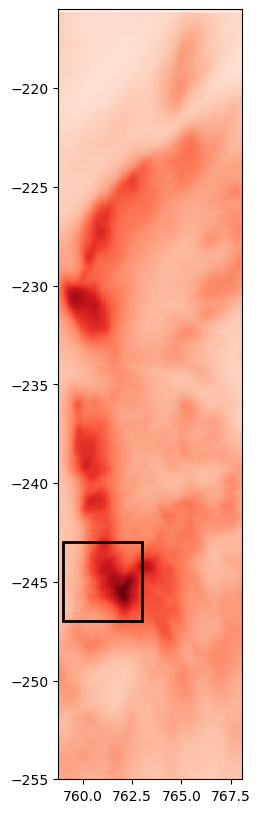

In [75]:
colors=tol_colors.tol_cset('muted')
    

dkist_blue = dkist_int[lowvisp:highvisp,caII_low-20,:]
dkist_center = dkist_int[lowvisp:highvisp,int(round(caII_high+caII_low)/2),:]

fig,ax=plt.subplots(figsize=(3,10));
ax.pcolormesh(xarr_caII,yarr_caII,np.transpose(dkist_avg),cmap='Reds')
ax.set_aspect('equal')
#ax.invert_xaxis()
#ax.invert_yaxis()



if feature == 'red':
    xmin = 760
    ymin = -247
    width = 4
    height = 4
if feature == 'blueshift':
    xmin = 759
    ymin = -233
    width = 6
    height = 11
if feature == 'symmetric':
    xmin = 759
    ymin = -241
    width = 3
    height = 6
if feature == 'deepheating':
    xmin = 759
    ymin = -247
    width = 4
    height = 4  
# Note: The x, y coordinates are in data space, matching the pcolormesh axes.

# 3. Create the Rectangle patch
# The Rectangle anchor point is the bottom-left corner (xmin, ymin)=

rect = Rectangle((xmin, ymin), width, height,linewidth=2, edgecolor='black', facecolor='none')

# 4. Add the patch to the axes
ax.add_patch(rect)


#ax.set_ylim([1500,500])
#ax.set_xlim([90,20])

ax.set_ylim([-255,-216])

ax.set_aspect('equal')
#ax.set_xticks([])
#ax.set_yticks([])

In [76]:
model_choiceqs = np.load(base+modelnameqs05)
caiih_inds = np.where((model_choiceqs['wl_rh']>396.7) & (model_choiceqs['wl_rh']< 397.94))

#define quiet sun stuff
model_choiceqs_wl = model_choiceqs['wl_rh'][caiih_inds]
model_choiceqs_int = model_choiceqs['int_rh'][caiih_inds]
model_choiceqs_wlshift = model_choiceqs_wl-lamb0
model_choiceqs_wlshift_hep = model_choiceqs_wl-lamb1

dkist_wl_shift = dkist_wl-lamb0
dkist_wl_shift_hep = dkist_wl-lamb1

yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)

In [77]:
modelscomp = []

for i in range(len(models)):
    selected = models[i]
    model_choice1 = np.load(base+selected)
    caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))

    model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
    model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
    model_choice1_wlshift = model_choice1_wl-lamb0
    model_choice1_wlshift_hep = model_choice1_wl-lamb1

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
    
    yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)
    if feature=='deepheating':

        if i==0:
            model_choiceqs = np.load(base+modelnameqs0_dh)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)
        
        if i==1:
            model_choiceqs = np.load(base+modelnameqs05_dh)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

        if i==2:
            model_choiceqs = np.load(base+modelnameqs1_dh)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

    if feature=='symmetric':
            # models.append('11Aug_Cclass_A_final_36s_5vt_mu1.npz') #time-consistent model for region AB
            # models.append('11Aug_Cclass_A_final_36s_7vt_mu0.5.npz')#same but at mu=0.5
            # models.append('11Aug_Cclass_A_final_36s_5vt_mu0.5.npz')#same but at mu=0.5
        if i==0:
            model_choiceqs = np.load(base+modelnameqs1)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

        if i==1 or i == 2:
            model_choiceqs = np.load(base+modelnameqs05)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

    if feature=='blueshift':
        model_choiceqs = np.load(base+modelnameqs1)
        caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))

        model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
        model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
        model_choice1_wlshift = model_choice1_wl-lamb0
        model_choice1_wlshift_hep = model_choice1_wl-lamb1
    
        model1_copy_int = model_choice1_int
        model1_copy_wl = model_choice1_wl
        yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
        
        yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

    if feature == 'red':
        # if feature == 'red':
        #     models.append('11Aug_Cclass_D_final_22s_mu1.npz') #region D, 22s (time-consistent; small redshift)
        #     models.append('11Aug_Cclass_A_final_7s_mu1.npz') #region AB, 7s (big redshift)
        #     models.append('rhf1d_11Aug_Cclass_TC_8s_mu1.npz') # region D, TC, 8s (some redshift)
        #     models.append('rhf1d_11Aug_Cclass_EB+TC_8s_mu1.npz') # region D, EB+TC, 8s (more redshift than TC
        if i == 0:
            model_choiceqs = np.load(base+modelnameqs1_EBd)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)
        if i == 1:
            model_choiceqs = np.load(base+modelnameqs1)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

        if i == 2:
            model_choiceqs = np.load(base+modelnameqs1_TCd)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)
        if i == 3:
            model_choiceqs = np.load(base+modelnameqs1_EBTCd)
            caiih_indsh20 = np.where((model_choice1['wl_rh']>396.7) & (model_choice1['wl_rh']< 397.94))
    
            model_choice1_wl = model_choice1['wl_rh'][caiih_indsh20]
            model_choice1_int = model_choice1['int_rh'][caiih_indsh20]
            model_choice1_wlshift = model_choice1_wl-lamb0
            model_choice1_wlshift_hep = model_choice1_wl-lamb1
        
            model1_copy_int = model_choice1_int
            model1_copy_wl = model_choice1_wl
            yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
            
            yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

    model_subtract1 = yconv1-yconvqs

    modelscomp.append(model_subtract1)

# for blueshift; load RADYN-only spectra
if feature=='blueshift':
    RADYN_pb = readsav(RADYNonly_proton)
    RADYN_ge = readsav(RADYNonly_ge)

    # for proton beam run
    q_pb = RADYN_pb['q']
    nq_pb = RADYN_pb['nq']
    qnorm_pb= RADYN_pb['qnorm']
    outintt_pb = RADYN_pb['outintt']
    nmu_pb = 5

    # for ge beam run
    q_ge = RADYN_ge['q']
    nq_ge = RADYN_ge['nq']
    qnorm_ge= RADYN_ge['qnorm']
    outintt_ge = RADYN_ge['outintt']
    nmu_ge = 5

    headon_caii_pb = outintt_pb[70,16,4,1:nq_pb[16]]-outintt_pb[0,16,4,1:nq_pb[16]]
    headon_caii_pb2 = outintt_pb[52,16,4,1:nq_pb[16]]-outintt_pb[0,16,4,1:nq_pb[16]]

    headon_caii_ge = outintt_ge[26,16,4,1:nq_ge[16]]-outintt_ge[0,16,4,1:nq_ge[16]]

    kr=16
    
    wavelengths = (doppler_shift_to_wavelength(396.846,q_pb[kr,:-1]*qnorm_pb))[0:100].value+396.846

    caiih_inds_RADYN = np.where((wavelengths>396.7) & (wavelengths< 397.94))

    # psf adjust, for PB
    model_choice1_wl = wavelengths[caiih_inds_RADYN]
    model_choice1_int = headon_caii_pb[caiih_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)

    modelscomp.append(yconv1)

    # psf adjust, for PB2
    model_choice1_wl = wavelengths[caiih_inds_RADYN]
    model_choice1_int = headon_caii_pb2[caiih_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)

    modelscomp.append(yconv1)
    
    # psf adjust, for GE
    model_choice1_wl = wavelengths[caiih_inds_RADYN]
    model_choice1_int = headon_caii_ge[caiih_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)
    
    modelscomp.append(yconv1)

    
if feature=='deepheating':
    RADYN_dh = readsav(RADYNonly_dh)

    # for proton beam run
    q_dh = RADYN_dh['q']
    nq_dh = RADYN_dh['nq']
    qnorm_dh= RADYN_dh['qnorm']
    outintt_dh = RADYN_dh['outintt']
    nmu_dh = 5
    kr=16
    
    hbeta_dh0 = outintt_dh[24,kr,0,1:nq_dh[kr]]-outintt_dh[0,kr,0,1:nq_dh[kr]]
    hbeta_dh05 = outintt_dh[24,kr,2,1:nq_dh[kr]]-outintt_dh[0,kr,2,1:nq_dh[kr]]
    hbeta_dh1 = outintt_dh[24,kr,4,1:nq_dh[kr]]-outintt_dh[0,kr,4,1:nq_dh[kr]]
    
    wavelengths = (doppler_shift_to_wavelength(396.847,q_dh[kr,:-1]*qnorm_dh))[0:100].value+396.847

    caiih_inds_RADYN = np.where((wavelengths>396.7) & (wavelengths< 397.94))

    # psf adjust, for DH
    model_choice1_wl = wavelengths[caiih_inds_RADYN]
    model_choice1_int = hbeta_dh0[caiih_inds_RADYN]
    model_choice2_int = hbeta_dh05[caiih_inds_RADYN]
    model_choice3_int = hbeta_dh1[caiih_inds_RADYN]


    model_choice1_wlshift = model_choice1_wl-lamb0
    model_choice2_wlshift = model_choice1_wl-lamb0
    model_choice3_wlshift = model_choice1_wl-lamb0


    model1_copy_int = model_choice1_int
    model2_copy_int = model_choice2_int.copy()
    model3_copy_int = model_choice3_int.copy()


    model1_copy_wl = model_choice1_wl.copy()
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)
    modelscomp.append(yconv1)

    yconv2=psf_adjust(model_choice1_wl,model2_copy_int,fwhm,dkist_wl)
    modelscomp.append(yconv2)

    yconv3=psf_adjust(model_choice1_wl,model3_copy_int,fwhm,dkist_wl)
    modelscomp.append(yconv3)    

Text(0.5, 0, 'Wavelength [nm]')

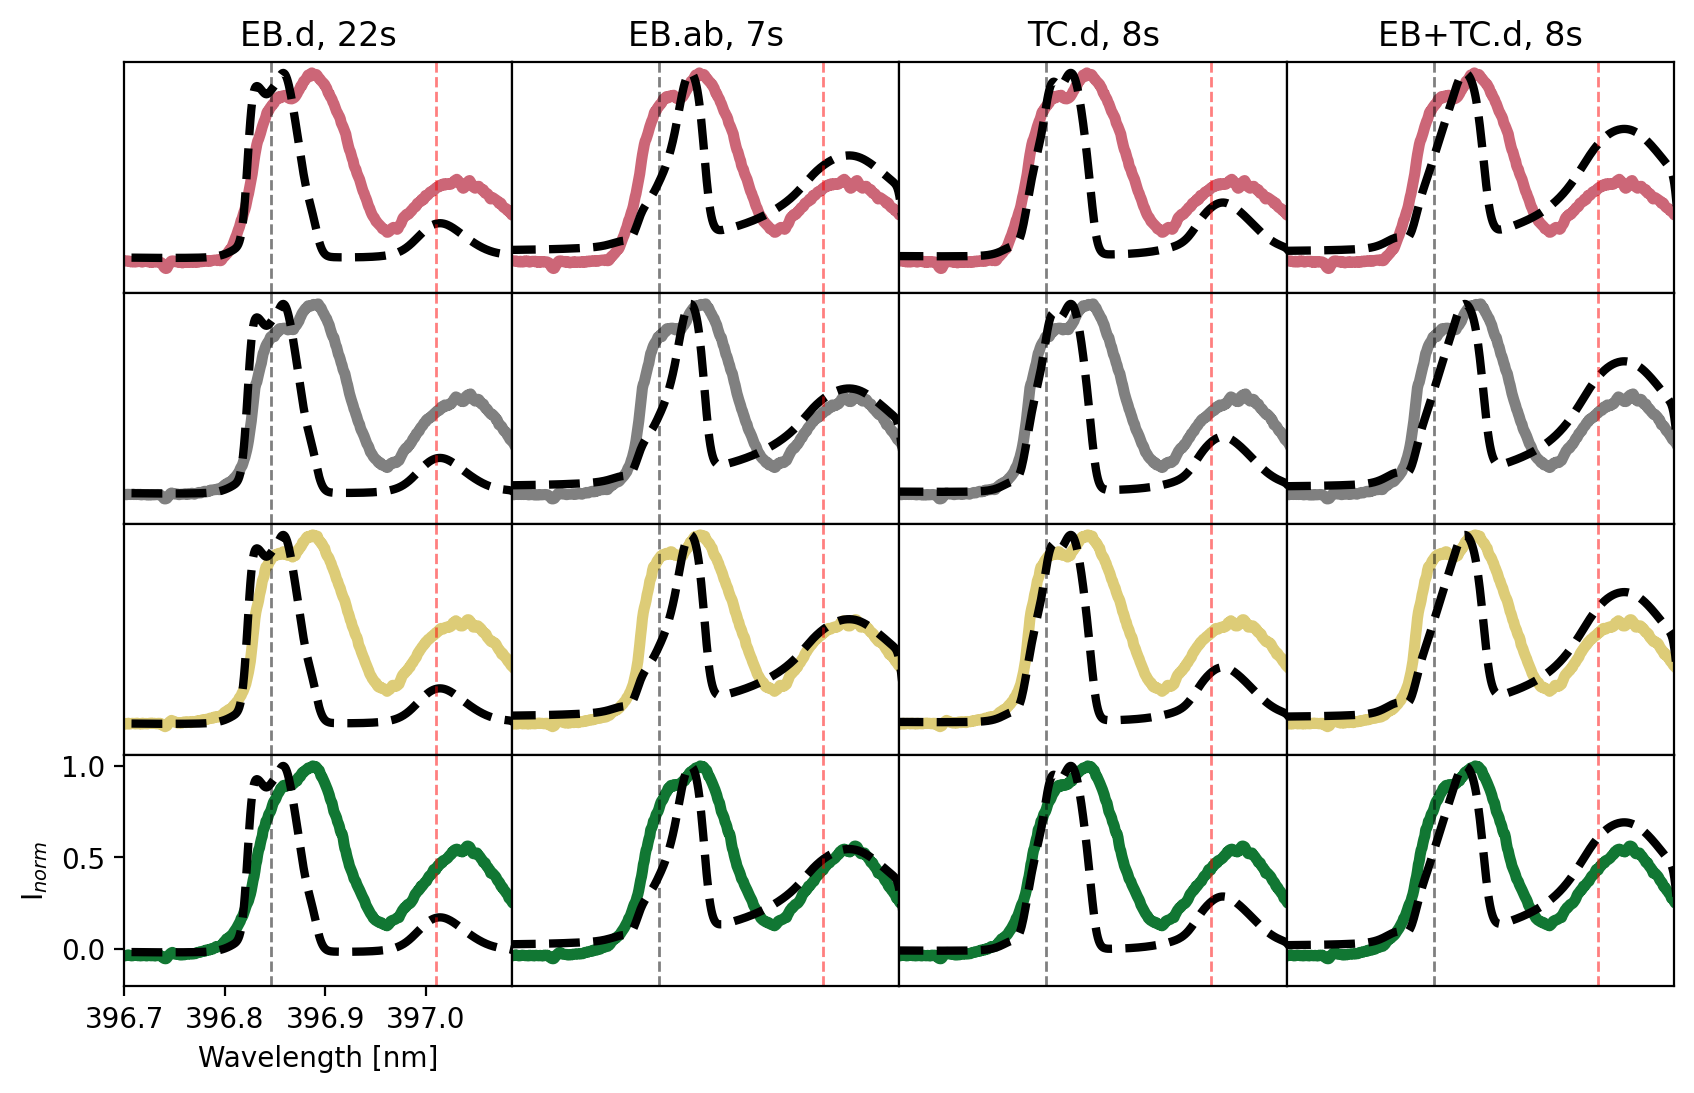

In [43]:
#for redshifts

npoints = 9
choice_is = [3,5,6,7]

#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--']
fig,ax=plt.subplots(4,4,dpi=200,figsize=(10,6))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        if i == 1:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=lowvisp+100),alpha=1,linewidth=4,c='grey')
        else:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=lowvisp+100),alpha=1,linewidth=4,c=colors[i])

        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j],contmin=lowvisp),linewidth=3,color='black',linestyle=modstyles[j])
        ax[i,j].set_xlim([396.7,397.086])

        if i!=3 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(396.846,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

        ax[i,j].axvline(397.01,c='red',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('EB.d, 22s')
ax[0,1].set_title('EB.ab, 7s')
ax[0,2].set_title('TC.d, 8s')
ax[0,3].set_title('EB+TC.d, 8s')

fig.subplots_adjust(hspace=0, wspace=0)

ax[3,0].set_ylabel(r'I$_{norm}$')
ax[3,0].set_xlabel('Wavelength [nm]')

Text(0.5, 0, 'Wavelength [nm]')

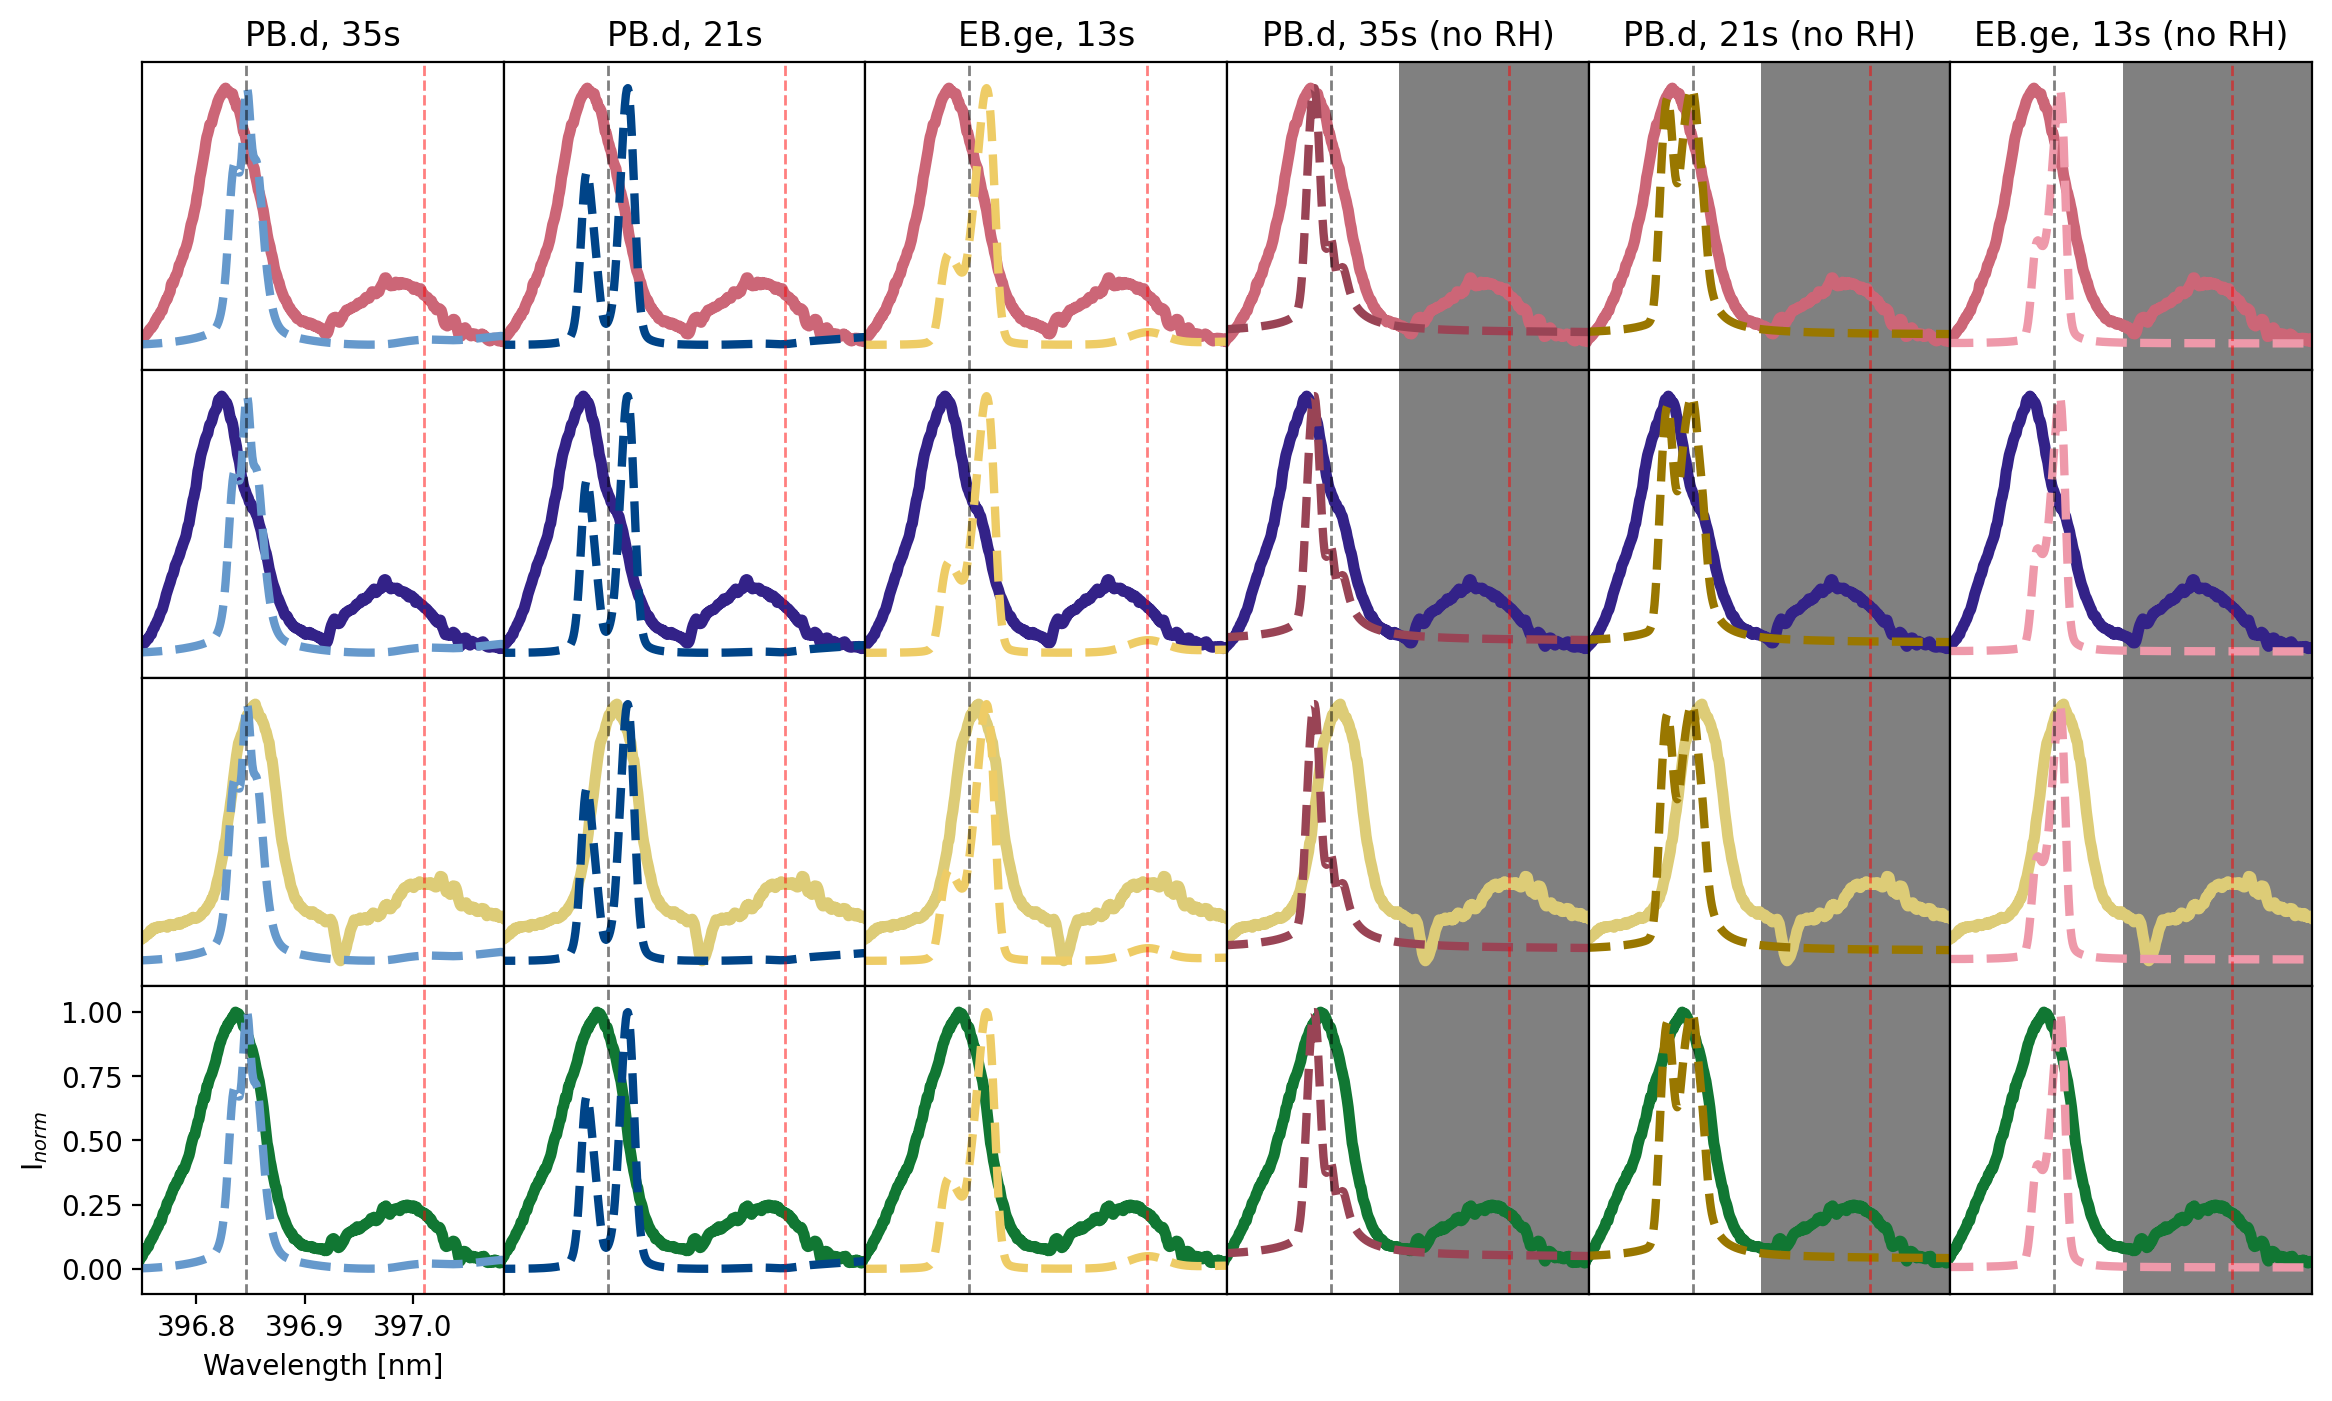

In [35]:
#for blueshifts

npoints = 9


#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('medium-contrast')

modstyles = ['--','--','--','--','--','--']
fig,ax=plt.subplots(4,6,dpi=200,figsize=(14,8))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=500),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([396.75,397.084])
        ax[i,j].set_ylim([-0.1,1.1])
        if i!=3 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        if j >2:
            ax[i,j].axvspan(396.91,397.09,color='grey')
            ax[i,j].axvspan(396.91,397.09,color='grey')

        

        ax[i,j].axvline(396.846,c='black',linestyle='dashed',linewidth=1,alpha=0.5)
        ax[i,j].axvline(397.01,c='red',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('PB.d, 35s')
ax[0,1].set_title('PB.d, 21s')
ax[0,2].set_title('EB.ge, 13s')
ax[0,3].set_title('PB.d, 35s (no RH)')
ax[0,4].set_title('PB.d, 21s (no RH)')
ax[0,5].set_title('EB.ge, 13s (no RH)')

fig.subplots_adjust(hspace=0, wspace=0)

ax[3,0].set_ylabel(r'I$_{norm}$')
ax[3,0].set_xlabel('Wavelength [nm]')

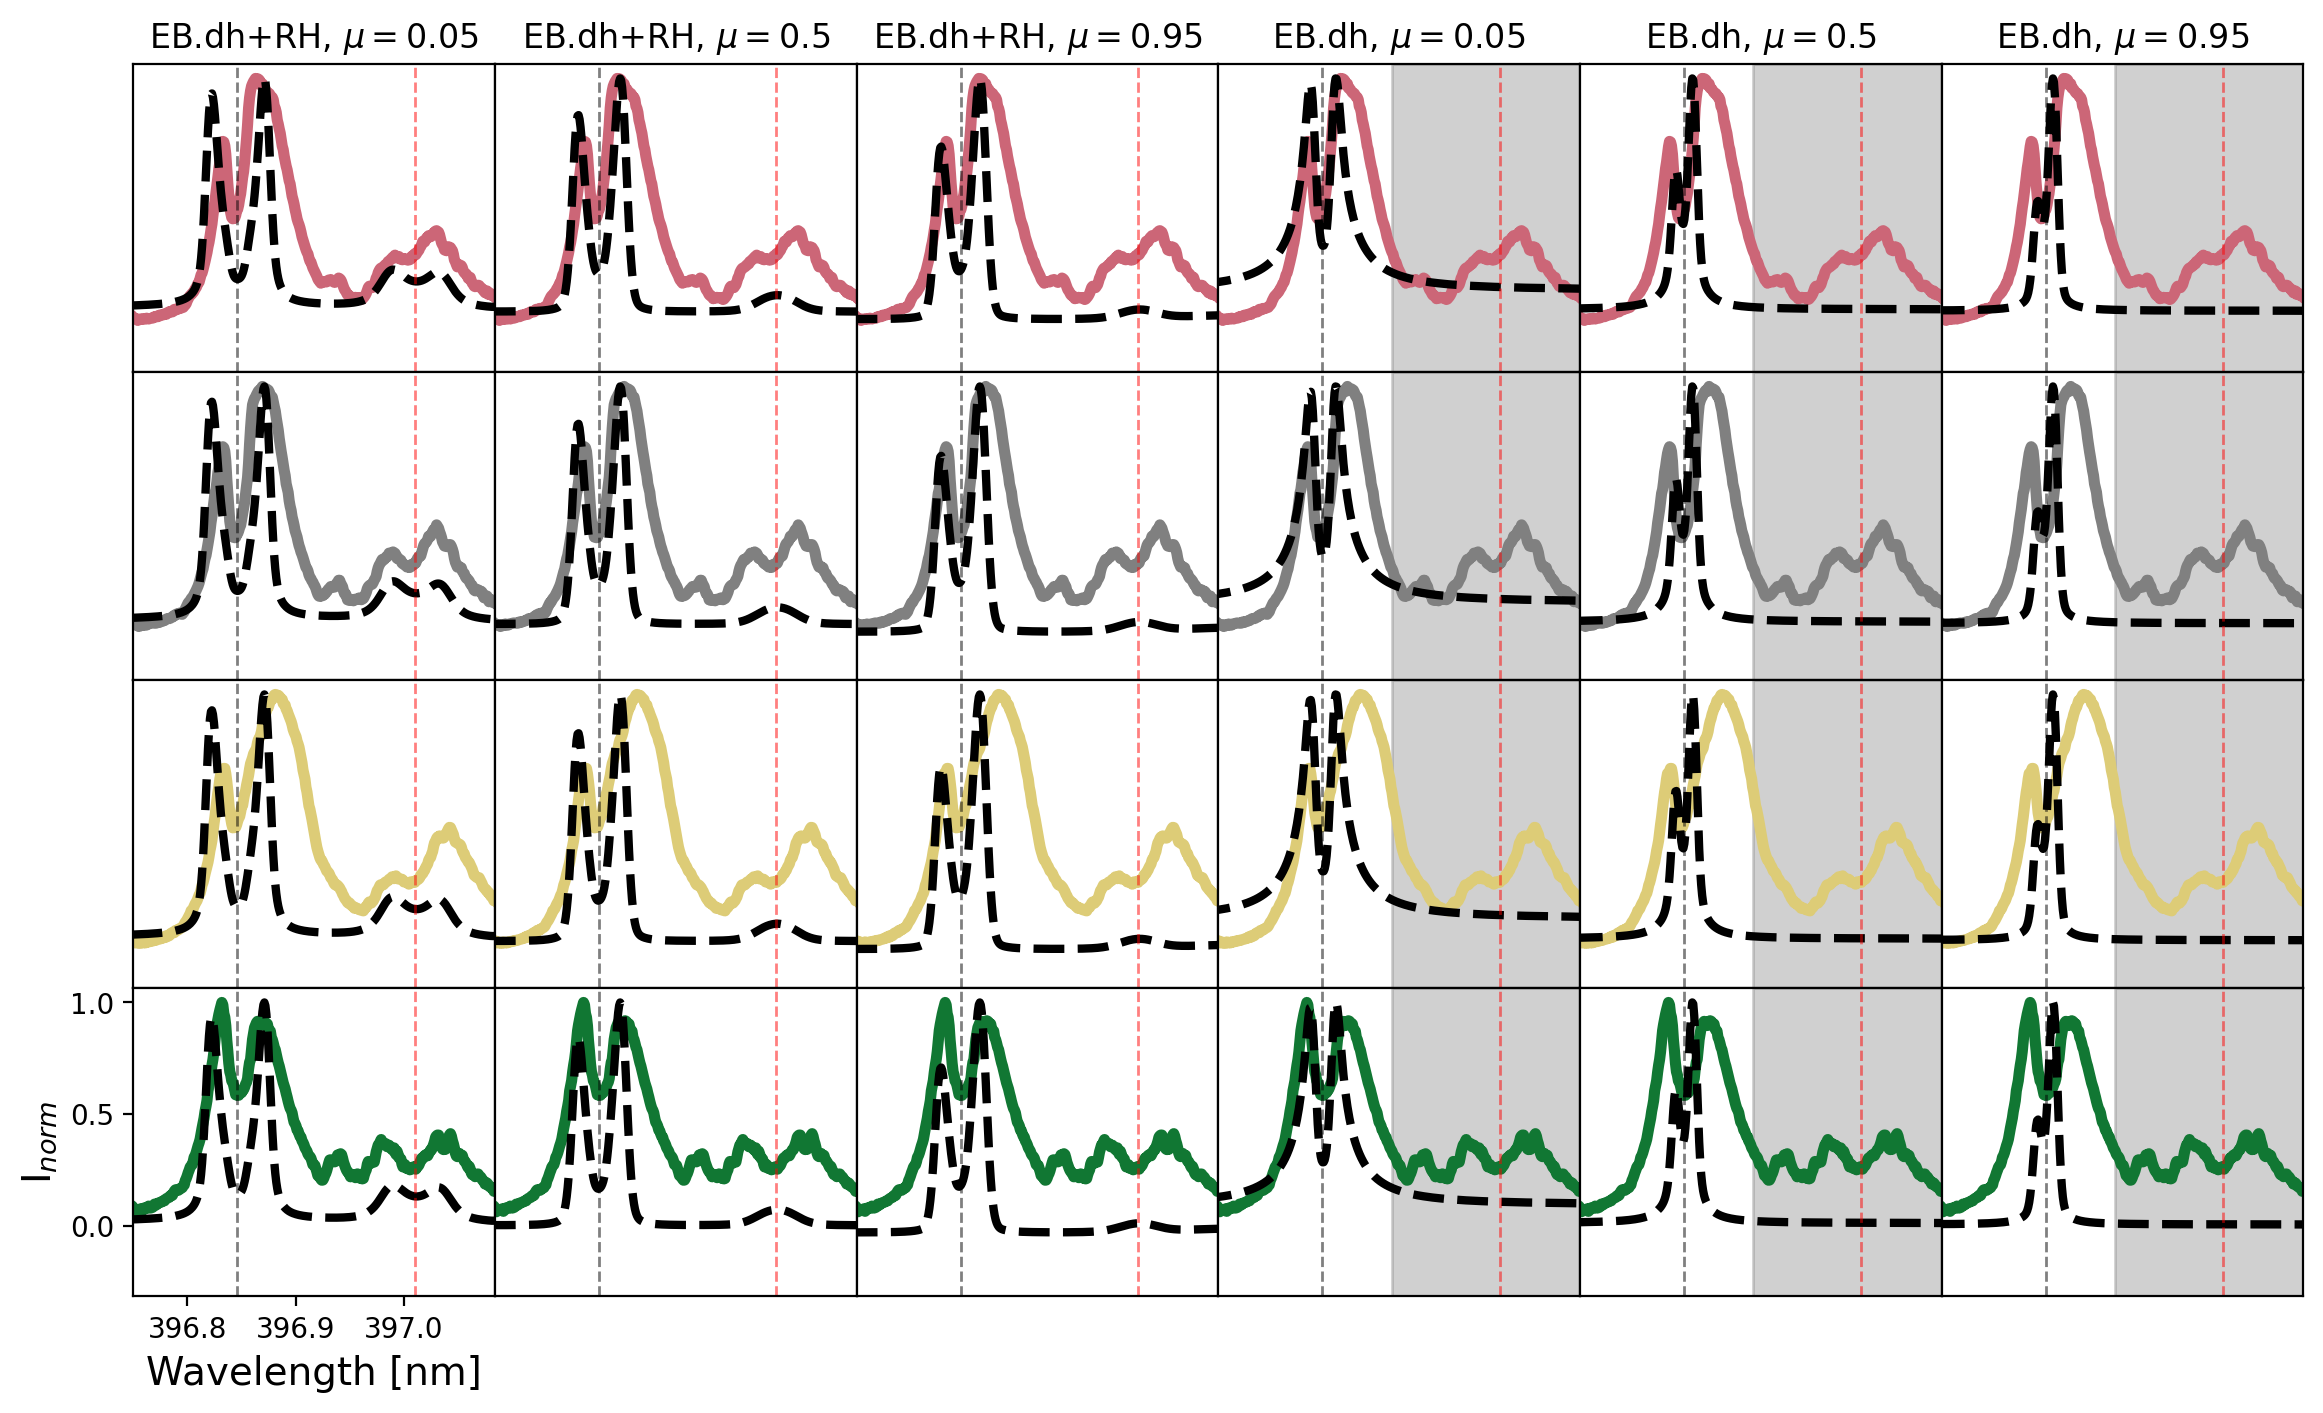

In [79]:
#for deepheating

npoints = 6


#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--','--','--']
fig,ax=plt.subplots(4,6,dpi=200,figsize=(14,8))
for i in range(4):
    for j in range(len(modelscomp)):
        if i==1:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=lowvisp),alpha=1,linewidth=4,c='grey')
        else:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=lowvisp),alpha=1,linewidth=4,c=colors[i])

        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j],contmin=lowvisp),linewidth=3,color='black',linestyle=modstyles[j])
        ax[i,j].set_xlim([396.75,397.084])

        if i!=3 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        if j >2:
            ax[i,j].axvspan(396.91,397.09,color='grey',alpha=0.2)
            ax[i,j].axvspan(396.91,397.09,color='grey',alpha=0.2)

        ax[i,j].axvline(396.846,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

        ax[i,j].axvline(397.01,c='red',linestyle='dashed',linewidth=1,alpha=0.5)


ax[0,0].set_title('EB.dh+RH, $\mu=0.05$')
ax[0,1].set_title('EB.dh+RH, $\mu=0.5$')
ax[0,2].set_title('EB.dh+RH, $\mu=0.95$')
ax[0,3].set_title('EB.dh, $\mu=0.05$')
ax[0,4].set_title('EB.dh, $\mu=0.5$')
ax[0,5].set_title('EB.dh, $\mu=0.95$')

fig.subplots_adjust(hspace=0, wspace=0)

ax[3,0].set_ylabel(r'I$_{norm}$',fontsize=14)
ax[3,0].set_xlabel('Wavelength [nm]',fontsize=14)

ax[3,0].set_xticks([396.8,396.9,397.0])
ax[3,0].set_yticks([0,0.5,1])

Text(0.5, 0, 'Wavelength [nm]')

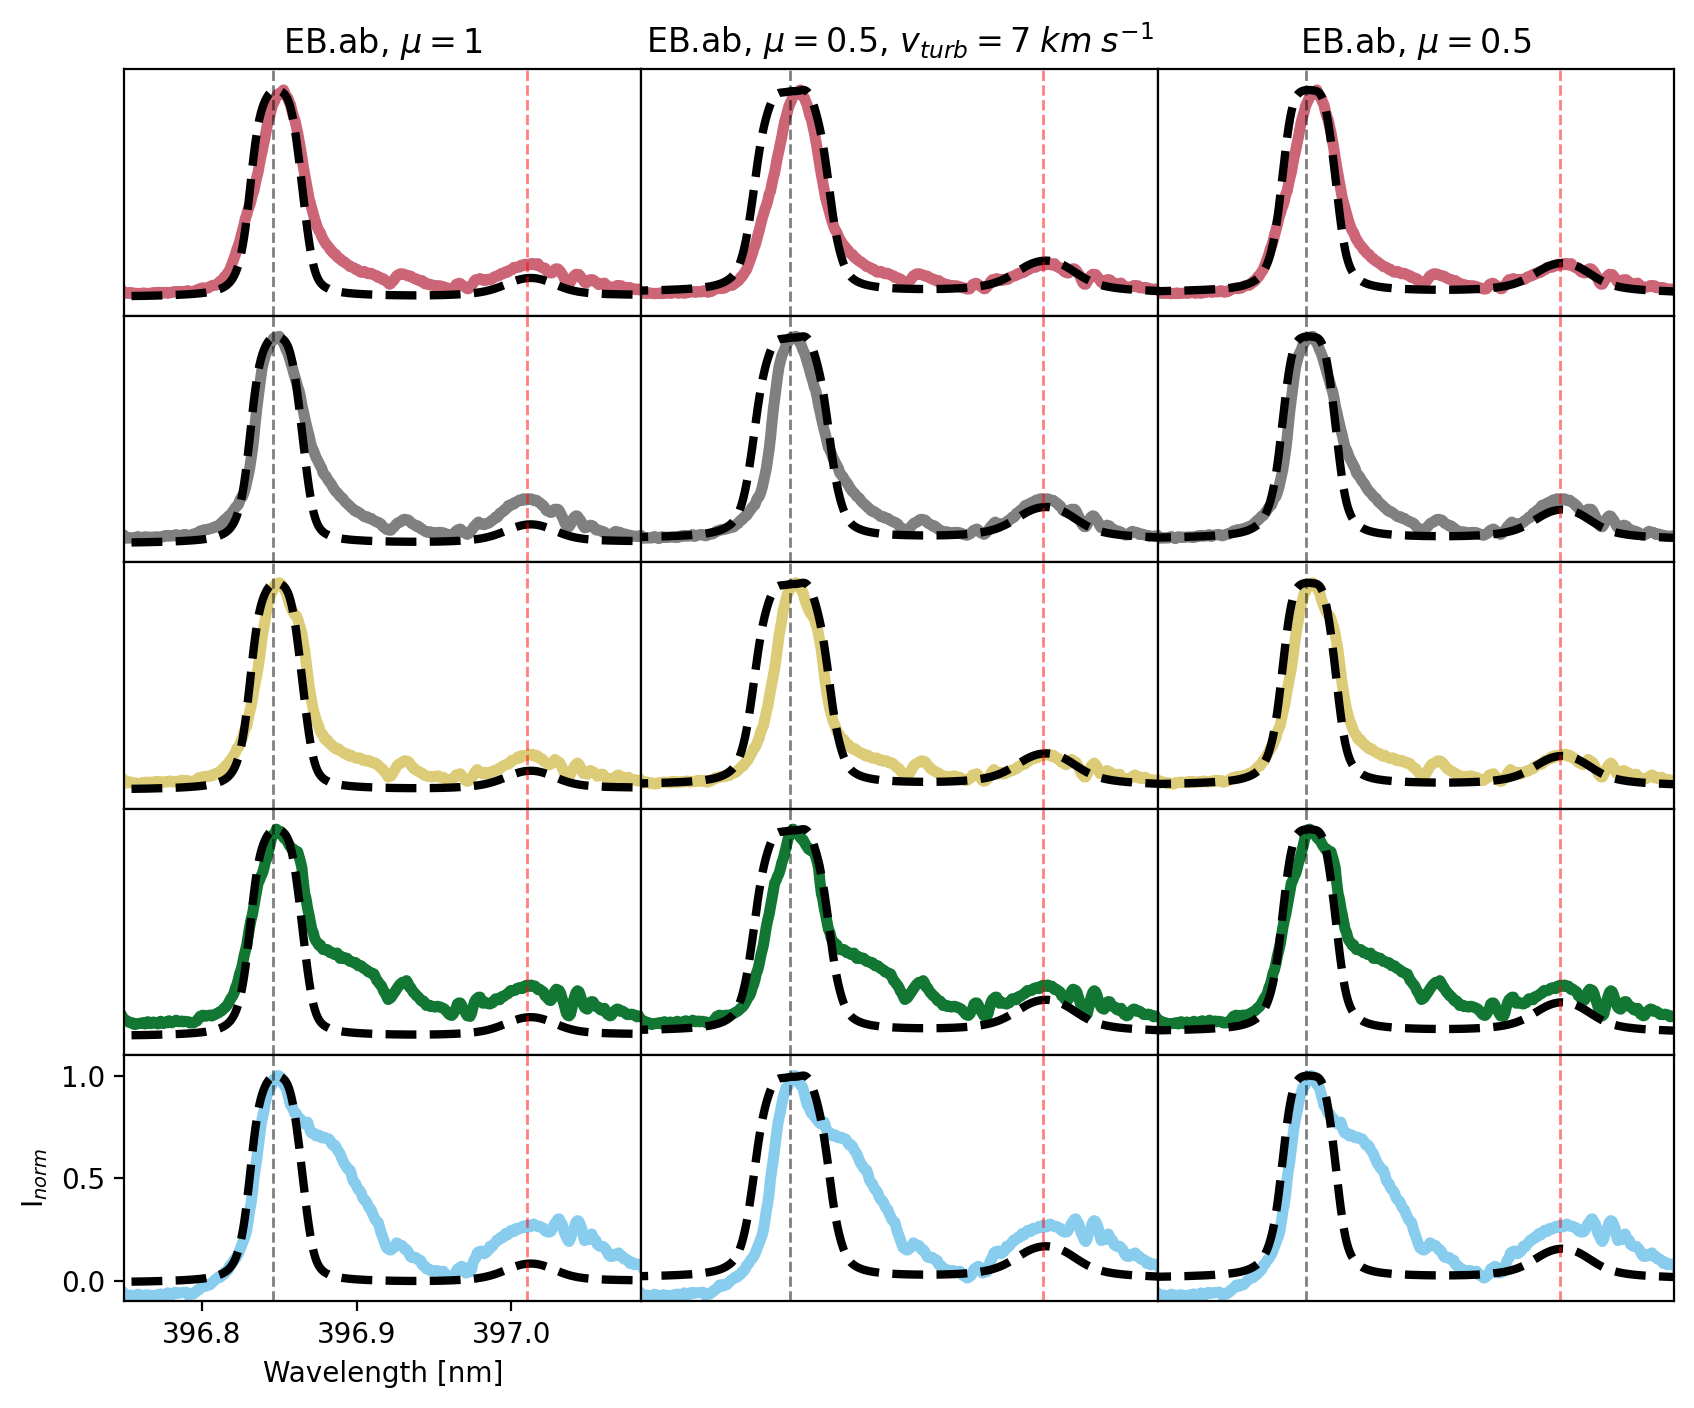

In [67]:
#for symm

npoints = 9


#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--']
fig,ax=plt.subplots(5,3,dpi=200,figsize=(10,8))
for i in range(len(choice_is)):
    for j in range(3):
        if i==1:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=lowvisp),alpha=1,linewidth=4,c='grey')
        else:
            ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=lowvisp),alpha=1,linewidth=4,c=colors[i])

        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j],contmin=lowvisp),linewidth=3,color='black',linestyle=modstyles[j])
        ax[i,j].set_xlim([396.75,397.084])
        ax[i,j].set_ylim([-0.1,1.1])
        if i!=4 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(396.846,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

        ax[i,j].axvline(397.01,c='red',linestyle='dashed',linewidth=1,alpha=0.5)

#all at 36s
ax[0,0].set_title('EB.ab, $\mu=1$')
ax[0,1].set_title('EB.ab, $\mu=0.5$, $v_{turb} = 7\;km\;s^{-1}$')
ax[0,2].set_title('EB.ab, $\mu=0.5$')



fig.subplots_adjust(hspace=0, wspace=0)

ax[4,0].set_ylabel(r'I$_{norm}$')
ax[4,0].set_xlabel('Wavelength [nm]')

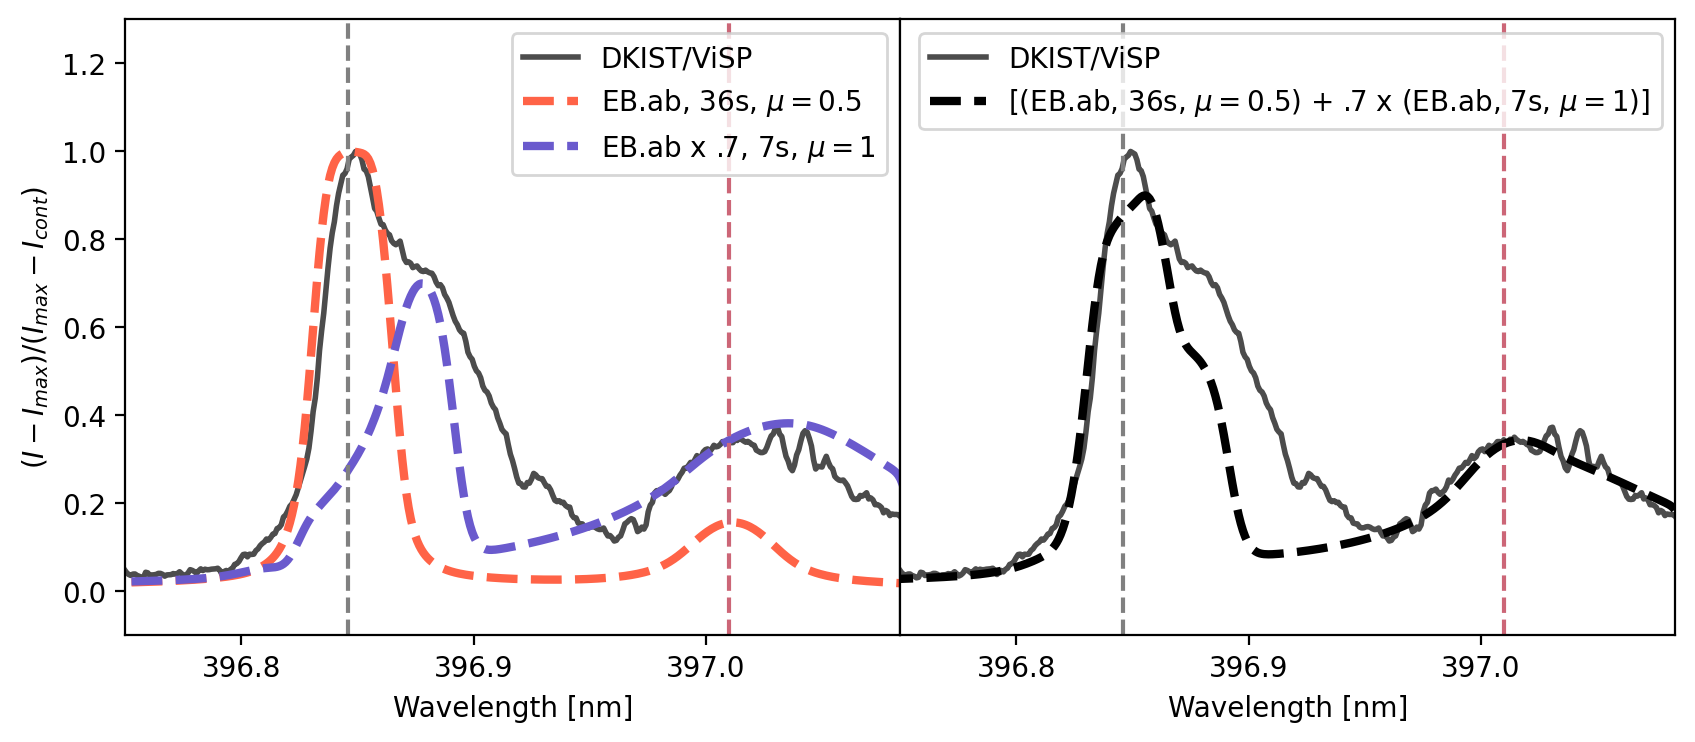

In [70]:
# for the last pixel - try to explain by combining two models, one redshifted?
fig,[ax,ax2]=plt.subplots(1,2,figsize=(10,4),dpi=200)
ax.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=100),alpha=.7,linewidth=2,c=colors[i],label='DKIST/ViSP')

ax.plot(dkist_wl,normalize_range(modelscomp[2],contmin=lowvisp),linewidth=3,color='tomato',linestyle=modstyles[j],label='EB.ab, 36s, $\mu=0.5$')
ax.plot(dkist_wl,normalize_range(modelscomp[3],contmin=lowvisp)*0.7,linewidth=3,color='slateblue',linestyle=modstyles[j],label='EB.ab x .7, 7s, $\mu=1$')

i=-1
ax.set_xlim([396.75,397.084])
ax.set_xticks([396.8,396.9,397])
ax.set_ylim([-0.1,1.3])

added = normalize_range(modelscomp[2],contmin=lowvisp)+normalize_range(modelscomp[3],contmin=lowvisp)*0.7
ax2.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=100),alpha=0.7,linewidth=2,c=colors[i],label='DKIST/ViSP')
ax2.plot(dkist_wl,normalize_range(added,contmin=lowvisp)*0.9,linewidth=3,color='black',linestyle=modstyles[j],label='[(EB.ab, 36s, $\mu=0.5$) + .7 x (EB.ab, 7s, $\mu=1$)]')

ax2.set_xlim([396.75,397.084])
ax2.set_xticks([396.8,396.9,397])
ax2.set_ylim([-0.1,1.3])
ax2.set_yticks([])
fig.subplots_adjust(wspace=0)

ax.set_ylabel(r'$(I-I_{max})/(I_{max}-I_{cont})$')
ax.set_xlabel('Wavelength [nm]')
ax2.set_xlabel('Wavelength [nm]')


ax.axvline(396.846,c='grey',linestyle='dashed')
ax.axvline(397.01,c='#CC6677',linestyle='dashed')

ax2.axvline(396.846,c='grey',linestyle='dashed')
ax2.axvline(397.01,c='#CC6677',linestyle='dashed')

ax.legend()
ax2.legend()


(396.75, 397.084)

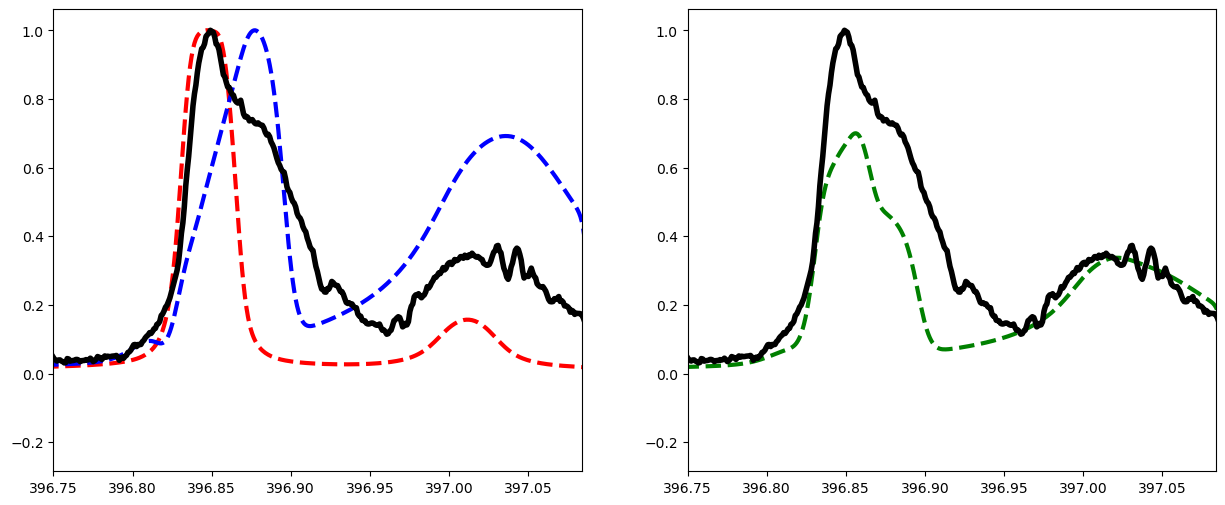

In [150]:
k=4
# for the last pixel - try to explain by combining two models, one redshifted?
fig,[ax,ax2]=plt.subplots(1,2,figsize=(15,6))
ax.plot(dkist_wl,normalize_range(modelscomp[2],contmin=lowvisp),linewidth=3,color='red',linestyle=modstyles[j])
ax.plot(dkist_wl,normalize_range(modelscomp[k],contmin=lowvisp),linewidth=3,color='blue',linestyle=modstyles[j])

i=-1
ax.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=100),alpha=1,linewidth=4,c=colors[i])
ax.set_xlim([396.75,397.084])

added = normalize_range(modelscomp[2],contmin=lowvisp)+normalize_range(modelscomp[k],contmin=lowvisp)

ax2.plot(dkist_wl,normalize_range(added,contmin=lowvisp),linewidth=3,color='green',linestyle=modstyles[j])

ax2.plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],contmin=100),alpha=1,linewidth=4,c=colors[i])
ax2.set_xlim([396.75,397.084])